In [1]:
from pycompwa.expertsystem.ui.system_control import (
    StateTransitionManager, InteractionTypes)
from pycompwa.expertsystem.amplitude.helicitydecay import (
    HelicityAmplitudeGeneratorXML)
from pycompwa.expertsystem.amplitude.canonicaldecay import (
   CanonicalAmplitudeGeneratorXML)
from pycompwa.expertsystem.state.particle import load_particle_list_from_xml
load_particle_list_from_xml("/home/leonard/work/work/Analyse/ComPWA/particle_list.xml")
# just a little function to print the intermediate states
def print_intermediate_states(solutions):
    from pycompwa.expertsystem.topology.graph import (
        get_intermediate_state_edges)
    print("intermediate states:")
    intermediate_states = set()
    for g in solutions:
        edge_id = get_intermediate_state_edges(g)[0]
        intermediate_states.add(g.edge_props[edge_id]['@Name'])
    print(intermediate_states)

### Step 2: Creating a data sample

In this section we will use the amplitude model created above to generate a data sample via hit & miss Monte Carlo.

Using this amplitude model in the c++ side of ComPWA is simple. The `create_intensity_and_kinematics()` helper function builds an Intensity and Kinematics object, as specified in the xml file. These can be used to generate our data sample.

In [2]:
import pycompwa.ui as pwa

particle_list = pwa.read_particles('ModelPPbarEta.xml')

kinematics = pwa.create_helicity_kinematics('ModelPPbarEta.xml', particle_list)

generator = pwa.EvtGenGenerator(kinematics.get_particle_state_transition_kinematics_info())

random_generator = pwa.StdUniformRealGenerator(12345)

phspsample = pwa.generate_phsp(100000, generator, random_generator)

intensity = pwa.create_intensity('ModelPPbarEta.xml', particle_list, kinematics, phspsample)

2019-11-06 14:31:31,850 INFO [default] HelicityKinematics::HelicityKinematics() | Initialized kinematics for reaction ( J/psi )->( p[ID=2] pbar[ID=3] eta[ID=4] )
Event position to final state ID mapping:
0: 2
1: 3
2: 4

2019-11-06 14:31:31,858 INFO [default] Generating phase-space MC: [100000 events] 




In [3]:
file = pwa.RootDataIO("my_ttree")
datasample = file.readData('ComPWA_example.root')
dataset = pwa.convert_events_to_dataset(datasample, kinematics)
phspdataset = pwa.convert_events_to_dataset(phspsample, kinematics)

Warning in cling::IncrementalParser::CheckABICompatibility():
  Possible C++ standard library mismatch, compiled with __GLIBCXX__ '20180720'
  Extraction of runtime standard library version was: '20181206'


### Step 3: Fitting

All parameter defined and used by the **Intensity** object, can be obtain for it by using the `parameters()` function. Just pass it an empty `ParameterList` object.

In [4]:
estimator, initial_parameters = pwa.create_unbinned_log_likelihood_function_tree_estimator(intensity, 
                                                                                           dataset)
minuitif = pwa.MinuitIF()
result = minuitif.optimize(estimator, initial_parameters)


2019-11-06 14:32:11,273 INFO [default] MinuitIF::optimize() | Number of parameters (free): 43 (32)
2019-11-06 14:32:11,290 INFO [default] MinuitIF::optimize() | Starting migrad: maxCalls=0 tolerance=0.1
2019-11-06 14:41:39,146 INFO [default] MinuitIF::optimize() | Migrad finished! Minimum is valid = 0
2019-11-06 14:41:39,149 INFO [default] MinuitIF::optimize() | Migrad failed to find minimum! Skip hesse and minos!
2019-11-06 14:41:39,150 INFO [default] MinuitIF::optimize() | Minimization finished! LH = -3633.125348


In [33]:
intensity.updateParametersFrom(result.final_parameters)
kinematics.create_all_subsystems()
dataset = pwa.convert_events_to_dataset(datasample, kinematics)
phspdataset = pwa.convert_events_to_dataset(phspsample, kinematics)

2019-11-06 15:02:10,538 INFO [default] creating all Subsystems!


In [34]:
pwa.create_rootplotdata("PPbarEtaPlot.root", kinematics, data_sample=dataset, 
                        phsp_sample=phspdataset, intensity=intensity)



2019-11-06 15:02:11,813 INFO [default] RootPlotData::write | calculating total intensity integral using phase space sample...





In [24]:
len(dataset.data[0])

10000

In [35]:
from pycompwa.plotting.rootplotdatareader import open_compwa_plot_data

plot_data = open_compwa_plot_data("PPbarEtaPlot.root")
print(plot_data.data.dtype.names, "\n",plot_data.fit_result_data.dtype.names)

('mSq_34_2', 'theta_34_2', 'phi_34_2', 'mSq_3_4_vs_2', 'theta_3_4_vs_2', 'phi_3_4_vs_2', 'mSq_24_3', 'theta_24_3', 'phi_24_3', 'mSq_4_2_vs_3', 'theta_4_2_vs_3', 'phi_4_2_vs_3', 'mSq_23_4', 'theta_23_4', 'phi_23_4', 'mSq_2_3_vs_4', 'theta_2_3_vs_4', 'phi_2_3_vs_4', 'weight') 
 ('mSq_34_2', 'theta_34_2', 'phi_34_2', 'mSq_3_4_vs_2', 'theta_3_4_vs_2', 'phi_3_4_vs_2', 'mSq_24_3', 'theta_24_3', 'phi_24_3', 'mSq_4_2_vs_3', 'theta_4_2_vs_3', 'phi_4_2_vs_3', 'mSq_23_4', 'theta_23_4', 'phi_23_4', 'mSq_2_3_vs_4', 'theta_2_3_vs_4', 'phi_2_3_vs_4', 'weight', 'intensity')


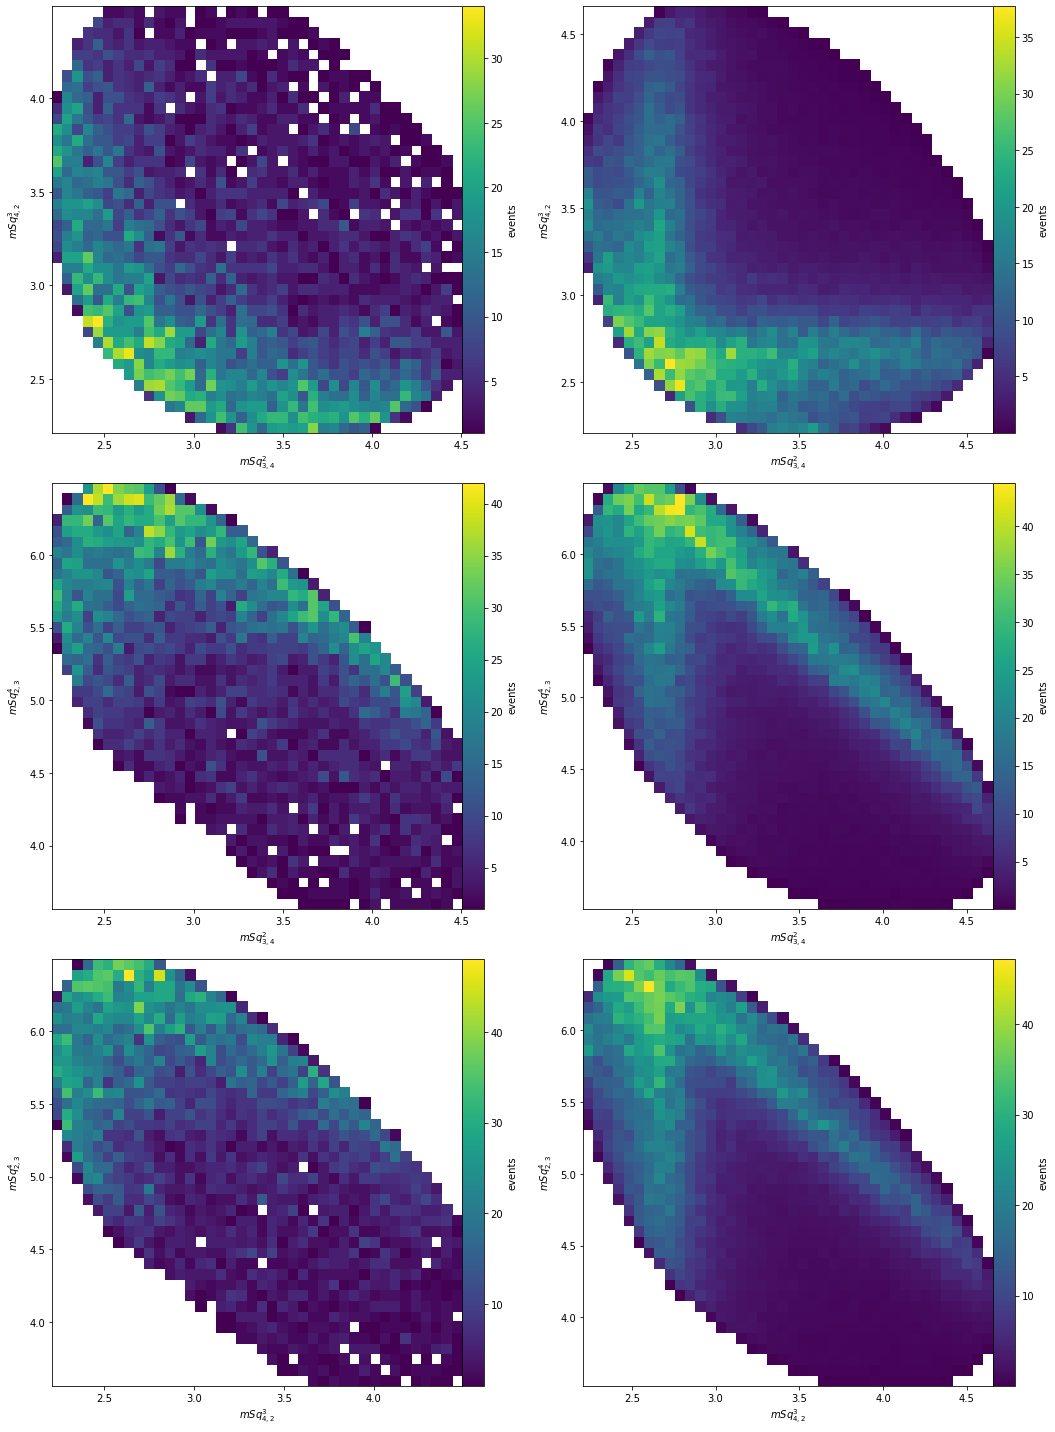

In [53]:
### from pycompwa.plotting import make_dalitz_plots
from matplotlib import rcParams
rcParams["figure.figsize"]=(15,20)
make_dalitz_plots(plot_data, None, bins=40)

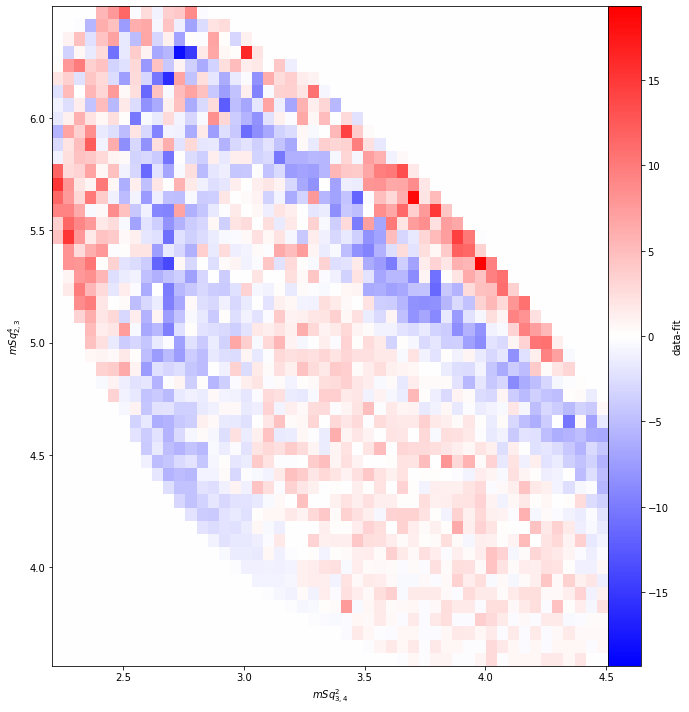

In [42]:
from pycompwa.plotting import make_difference_plot_2d
mpl.rcParams["figure.figsize"]=(10,10)

make_difference_plot_2d(plot_data,["mSq_3_4_vs_2", "mSq_2_3_vs_4"], bins=50)

In [50]:
for var in result.final_parameters:
    print("{}\n {}+-{}".format(var.name, var.value, var.error))
    print()

strength_incoherent
 1.0+-(0.0, 0.0)

Mass_jpsi
 3.0969+-(0.0, 0.0)

Mass_N(1650)-
 1.65+-(0.0, 0.0)

Mass_proton
 0.938272081+-(0.0, 0.0)

Mass_antiproton
 0.938272081+-(0.0, 0.0)

Mass_eta
 0.547862+-(0.0, 0.0)

Width_N(1650)-
 0.125+-(0.0, 0.0)

Radius_N(1650)-
 2.5+-(0.0, 0.0)

Magnitude_J/psi_to_N(1650)-+p_L_1.0_S_1.0;N(1650)-_to_eta+pbar_L_0.0_S_0.5;
 -0.6012274088326551+-(0.34708437687295884, 0.34708437687295884)

Phase_J/psi_to_N(1650)-+p_L_1.0_S_1.0;N(1650)-_to_eta+pbar_L_0.0_S_0.5;
 0.036917185286498885+-(0.5031494713627951, 0.5031494713627951)

Magnitude_J/psi_to_N(1650)-+p_L_1.0_S_0.0;N(1650)-_to_eta+pbar_L_0.0_S_0.5;
 3.574972261140399+-(2.602719222203408, 2.602719222203408)

Phase_J/psi_to_N(1650)-+p_L_1.0_S_0.0;N(1650)-_to_eta+pbar_L_0.0_S_0.5;
 -1.2214710977556222+-(0.13541257300447537, 0.13541257300447537)

Mass_N(1650)+
 1.65+-(0.0, 0.0)

Width_N(1650)+
 0.125+-(0.0, 0.0)

Radius_N(1650)+
 2.5+-(0.0, 0.0)

Magnitude_J/psi_to_N(1650)++pbar_L_1.0_S_1.0;N(1650)+_to_eta+p

In [46]:
var.name

'Phase_J/psi_to_N(1650)++pbar_L_0.0_S_1.0;N(1650)+_to_eta+p_L_1.0_S_0.5;'